In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch import nn
from simulators import SimulatorLetter
import scipy.ndimage
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import RatioEstimatorCube
from unet import UNet

  0%|          | 0/1 [00:00<?, ?it/s]

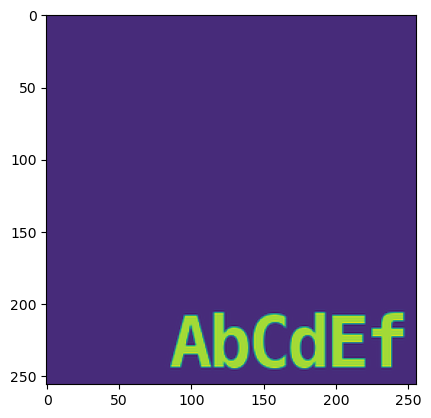

In [3]:
sim = SimulatorLetter()
samples0 = sim.sample(1, conditions = dict(rot = np.zeros(6), pos = np.array([[0.93, 0.35+i/8] for i in range(6)])))
plt.imshow(samples0['mu'][0])

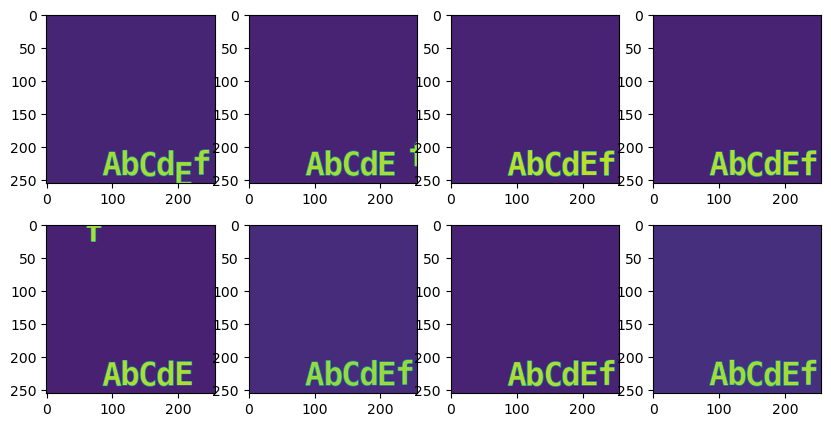

In [313]:
#bounds = None
sim = SimulatorLetter(bounds = new_bounds)
plt.figure(figsize = (10, 5))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    sample = sim.sample()
    t = sample['mu']
#    print(sample['pos'][0])
    plt.imshow(t)

In [314]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.unet = UNet(1, 6, s = 4)
    
    def forward(self, A, B):
        mu = A['mu']
        pos = B['pos'][..., :6, :]

        X = pos[...,0]*1., pos[...,1]*1.
        pos[...,1], pos[...,0] = X

        pos = pos + torch.randn_like(pos)*0.00
        output = self.unet(mu.unsqueeze(1))
        u_pos = RatioEstimatorCube.linear_rescale(pos, [[0, 1], [0, 1]], [[-0.9, 0.9], [-0.9, 0.9]])

        output, u_pos = swyft.equalize_tensors(output, u_pos)
        output2 = torch.nn.functional.grid_sample(output, u_pos.unsqueeze(-2)).squeeze(-1)
        output3 = output2[:,0]*1.
        output3[:,1] = output2[:,1,1]*1.
        output3[:,2] = output2[:,2,2]*1.
        output3[:,3] = output2[:,3,3]*1.
        output3[:,4] = output2[:,4,4]*1.
        output3[:,5] = output2[:,5,5]*1.
        logratios = swyft.LogRatioSamples(params = pos, logratios = output3, parnames=np.array([
            ['z[0,0]', 'z[0,1]'],
            ['z[1,0]', 'z[1,1]'],
            ['z[2,0]', 'z[2,1]'],
            ['z[3,0]', 'z[3,1]'],
            ['z[4,0]', 'z[4,1]'],
            ['z[5,0]', 'z[5,1]'],
        ]))
        return logratios
    
net = Network()

In [315]:
sim = SimulatorLetter(bounds = new_bounds)
samples = sim.sample(4096)
dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 128)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [316]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 30, precision = 32)
trainer.fit(net, dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | UNet | 1.9 M 
------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [304]:
prior_samples = sim.sample(400000, targets = ['pos'])
results = trainer.infer(net, samples0, prior_samples)
#i = 0
#swyft.plot_2d(results, 'z[%i,0]'%i, 'z[%i,1]'%i, smooth = 1)

  0%|          | 0/400000 [00:00<?, ?it/s]

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 9it [00:00, ?it/s]

In [309]:
def get_new_bounds(results):
    bounds = []
    for i in range(6):
        X, W = swyft.get_weighted_samples(results, ['z[%i,0]'%i, 'z[%i,1]'%i])
        mask = W > 0.5
        print(W[~mask].sum()/W.sum(), sum(mask))
        bounds.append(X[mask][:4096])
    bounds = torch.stack(bounds)
    return bounds

In [310]:
bounds = get_new_bounds(results)

tensor(0.0094) tensor(6118)
tensor(0.0079) tensor(9271)
tensor(0.0054) tensor(8909)
tensor(0.0044) tensor(6406)
tensor(0.0016) tensor(5169)
tensor(0.0136) tensor(7475)


In [311]:
new_bounds = bounds*1.
new_bounds[..., 0] = bounds[..., 1]
new_bounds[..., 1] = bounds[..., 0]

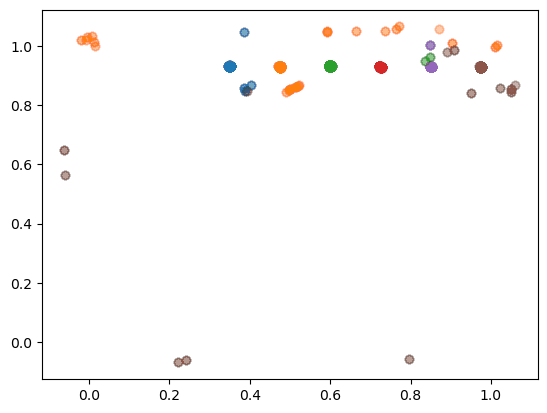

In [312]:
for i in range(6):
    plt.scatter(bounds[i, :,0], bounds[i, :,1], alpha = 0.01)

##### 